In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline



In [ ]:
df = pd.read_csv("Research.Marketing.csv")

recency_q75 = df['prompt.customer_segmentation.rfm.recency'].quantile(0.75)
freq_q25 = df['prompt.customer_segmentation.rfm.frequency'].quantile(0.25)

df['churn_label'] = ((df['prompt.customer_segmentation.rfm.recency'] >= recency_q75) &
                     (df['prompt.customer_segmentation.rfm.frequency'] <= freq_q25)).astype(int)

print(df['churn_label'].value_counts())
print(df['churn_label'].value_counts(normalize=True))
print("recency_q75:", recency_q75)
print("freq_q25:", freq_q25)
print(df.info())

churn_label
0    91104
1     8896
Name: count, dtype: int64
churn_label
0    0.91104
1    0.08896
Name: proportion, dtype: float64
recency_q75: 8.0
freq_q25: 3.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                                                                   Non-Null Count   Dtype  
---  ------                                                                   --------------   -----  
 0   _id                                                                      100000 non-null  object 
 1   prompt.customer_profile.name                                             100000 non-null  object 
 2   prompt.customer_profile.age                                              100000 non-null  int64  
 3   prompt.customer_profile.gender                                           100000 non-null  object 
 4   prompt.customer_profile.location                                         100000 non-null  object 
 5   pr

In [3]:
df.columns = df.columns.str.replace('prompt.', '', regex=False)

print(df.columns)


Index(['_id', 'customer_profile.name', 'customer_profile.age',
       'customer_profile.gender', 'customer_profile.location',
       'customer_behavior.purchase_history[0].product',
       'customer_behavior.purchase_history[0].price',
       'customer_behavior.cart_abandonment[0].product',
       'customer_behavior.cart_abandonment[0].date_added',
       'customer_behavior.cart_abandonment[0].date_abandoned',
       'customer_behavior.engagement_history',
       'customer_segmentation.demographics.city',
       'customer_segmentation.demographics.country',
       'customer_segmentation.behavioral_segments.frequency_of_purchases',
       'customer_segmentation.behavioral_segments.average_order_value',
       'customer_segmentation.rfm.recency',
       'customer_segmentation.rfm.frequency',
       'customer_segmentation.rfm.monetary_value', 'product_data.product_id',
       'product_data.product_name', 'product_data.short_description',
       'product_data.category', 'product_data.prici

In [4]:
df['product_data.inventory.restock_date']=pd.to_datetime(df['product_data.inventory.restock_date'], errors='coerce')
df['product_data.inventory.restock_year']=df['product_data.inventory.restock_date'].dt.year.astype(int)
df['product_data.inventory.restock_month']=df['product_data.inventory.restock_date'].dt.month.astype(int)
df['product_data.inventory.restock_day']=df['product_data.inventory.restock_date'].dt.day.astype(int)

df.drop(columns=['customer_profile.name','product_data.inventory.restock_date'],inplace=True)

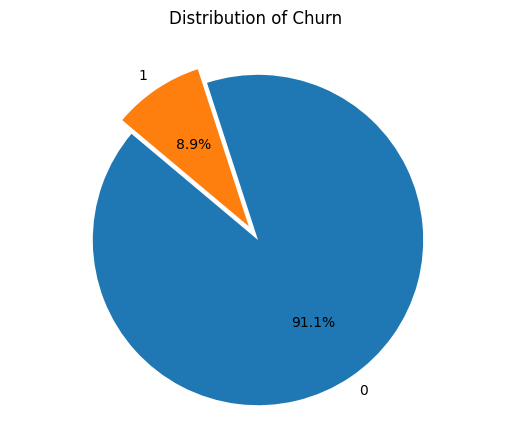

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

churn_count=df['churn_label'].value_counts()

plt.pie(churn_count,labels=churn_count.index,autopct='%1.1f%%',startangle=140,explode=[0.1,0.0])
plt.axis('equal')
plt.title('Distribution of Churn \n')
plt.ylabel('')
plt.show()

In [6]:
# Handle categorical and numeric
cat_cols = [c for c in df if df[c].dtype == 'object']
num_cols = [c for c in df if c not in cat_cols]

'''enc=OneHotEncoder(sparse_output=False, handle_unknown='ignore',max_categories=50)
encoded_array = enc.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded_array, columns=enc.get_feature_names_out(cat_cols))
df_final = df.drop(columns=cat_cols).reset_index(drop=True).join(encoded_df)
print(df_final.head())'''


"enc=OneHotEncoder(sparse_output=False, handle_unknown='ignore',max_categories=50)\nencoded_array = enc.fit_transform(df[cat_cols])\nencoded_df = pd.DataFrame(encoded_array, columns=enc.get_feature_names_out(cat_cols))\ndf_final = df.drop(columns=cat_cols).reset_index(drop=True).join(encoded_df)\nprint(df_final.head())"

In [7]:
from sklearn.preprocessing import LabelEncoder

df_final = df.copy()
label_encoders = {}  # Dictionary to store LabelEncoder for each column

for col in cat_cols:
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col].astype(str))
    label_encoders[col] = le  # Save the encoder


In [8]:

y=df_final['churn_label']
X=df_final.drop(columns=['churn_label'],axis=1)

scaling_cols=['customer_profile.age',
 'customer_behavior.purchase_history[0].price',
 'customer_segmentation.behavioral_segments.frequency_of_purchases',
 'customer_segmentation.behavioral_segments.average_order_value',
 'customer_segmentation.rfm.recency',
 'customer_segmentation.rfm.frequency',
 'customer_segmentation.rfm.monetary_value',
 'product_data.pricing.current_price',
 'product_data.pricing.previous_price',
 'product_data.inventory.stock_level',
]
scaler=StandardScaler()
X[scaling_cols] = scaler.fit_transform(X[scaling_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44, stratify=y)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = df_final['churn_label']
X = df_final.drop(columns=['churn_label'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44, stratify=y)

scaling_cols = [
    'customer_profile.age',
    'customer_behavior.purchase_history[0].price',
    'customer_segmentation.behavioral_segments.frequency_of_purchases',
    'customer_segmentation.behavioral_segments.average_order_value',
    'customer_segmentation.rfm.recency',
    'customer_segmentation.rfm.frequency',
    'customer_segmentation.rfm.monetary_value',
    'product_data.pricing.current_price',
    'product_data.pricing.previous_price',
    'product_data.inventory.stock_level',
]

scaler = StandardScaler()

X_train[scaling_cols] = scaler.fit_transform(X_train[scaling_cols])

X_test[scaling_cols] = scaler.transform(X_test[scaling_cols])


In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced',random_state=42, max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

c:\Users\Surendra Sir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.99      0.88      0.93     22776
           1       0.43      0.92      0.59      2224

    accuracy                           0.88     25000
   macro avg       0.71      0.90      0.76     25000
weighted avg       0.94      0.88      0.90     25000



In [11]:
churned_customers = X_test[y_pred == 1].copy()

In [12]:
churned_customers[scaling_cols] = scaler.inverse_transform(churned_customers[scaling_cols])

In [13]:
churned_customers['customer_behavior.cart_abandonment[0].product'] = label_encoders['customer_behavior.cart_abandonment[0].product'].inverse_transform(
    churned_customers['customer_behavior.cart_abandonment[0].product']
)

churned_customers['customer_behavior.purchase_history[0].product'] = label_encoders['customer_behavior.purchase_history[0].product'].inverse_transform(
    churned_customers['customer_behavior.purchase_history[0].product']
)

churned_customers['product_data.category'] = label_encoders['product_data.category'].inverse_transform(
    churned_customers['product_data.category']
)

churned_customers['customer_profile.location']=label_encoders['customer_profile.location'].inverse_transform(
    churned_customers['customer_profile.location']
)

In [14]:
churned_customers

,_id,customer_profile.age,customer_profile.gender,customer_profile.location,customer_behavior.purchase_history[0].product,customer_behavior.purchase_history[0].price,customer_behavior.cart_abandonment[0].product,customer_behavior.cart_abandonment[0].date_added,customer_behavior.cart_abandonment[0].date_abandoned,customer_behavior.engagement_history,...,product_data.short_description,product_data.category,product_data.pricing.current_price,product_data.pricing.previous_price,product_data.inventory.stock_level,product_data.popularity.sales_trend,response.message_body,product_data.inventory.restock_year,product_data.inventory.restock_month,product_data.inventory.restock_day
12141,12141,58.0,0,"East Darrylton, Burundi",Air Fryer,5.99,Laundry Detergent,16037,18055,35299,...,4,Appliances,499.99,599.99,14.0,14,90027,1992,11,1
10983,10983,39.0,1,"South Davidside, Japan",Whole Grain Bread,89.99,Vacuum Cleaner,4285,7117,19841,...,9,Appliances,129.99,155.99,12.0,16,84847,1996,8,9
90986,90986,40.0,1,"East Lorihaven, Tunisia",Whole Grain Bread,999.99,Washing Machine,4527,3392,6287,...,7,Electronics,99.99,119.99,94.0,40,70810,1984,3,14
14,14,48.0,1,"New Shawn, Gibraltar",Almond Milk,199.99,Whole Grain Bread,6804,11941,21097,...,9,Appliances,129.99,155.99,46.0,27,61937,2009,1,5
27992,27992,41.0,1,"Kyleland, Belize",Shampoo,89.99,Laptop,8219,15979,56911,...,10,Commodities,6.99,8.39,15.0,38,87120,1997,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78338,78338,39.0,0,"North Margaretton, Timor-Leste",Air Fryer,10.99,Toothpaste,7828,6052,61676,...,10,Commodities,6.99,8.39,83.0,14,30010,1991,4,22
19578,19578,34.0,1,"Lake Matthew, Ethiopia",Vacuum Cleaner,2.99,Laundry Detergent,2109,9566,29596,...,5,Commodities,2.99,3.59,92.0,23,86854,1984,6,29
35700,35700,53.0,1,"North Kimberlyport, Cayman Islands",Laptop,3.49,Laptop,3396,11791,53679,...,9,Appliances,129.99,155.99,64.0,19,1611,2023,7,8
82622,82622,30.0,0,"Richardsonstad, Palestinian Territory",Toothpaste,6.99,Air Fryer,4806,17488,32434,...,0,Electronics,199.99,239.99,12.0,45,15099,1981,5,11


In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules


churn_customers = df[df['churn_label'] == 1]

purchase_basket = (churn_customers.groupby(['_id', 'customer_behavior.purchase_history[0].product'])
                  .size().unstack(fill_value=0))


abandonment_basket = (churn_customers.groupby(['_id', 'customer_behavior.cart_abandonment[0].product'])
                     .size().unstack(fill_value=0))


category_basket = (churn_customers.groupby(['_id', 'product_data.category'])
                  .size().unstack(fill_value=0))


age_basket = (churn_customers.groupby(['_id', 'customer_profile.age'])
                  .size().unstack(fill_value=0))


location_basket = (churn_customers.groupby(['_id', 'customer_profile.location'])
                  .size().unstack(fill_value=0))


hybrid_basket = purchase_basket.add(abandonment_basket, fill_value=0).add(category_basket, fill_value=0)


hybrid_basket = (hybrid_basket > 0).astype(int)

print(hybrid_basket.head())
print(f"Hybrid basket shape: {hybrid_basket.shape}")


                          Air Fryer  Almond Milk  Appliances  Commodities  \
_id                                                                         
6899eddccad9ad665c196945          0            0           1            0   
6899eddccad9ad665c19694e          0            0           0            1   
6899eddccad9ad665c196955          0            0           0            1   
6899eddccad9ad665c196957          0            0           1            0   
6899eddccad9ad665c19695b          0            0           0            1   

                          Electronics  Groceries  Laptop  Laundry Detergent  \
_id                                                                           
6899eddccad9ad665c196945            0          0       0                  1   
6899eddccad9ad665c19694e            0          0       1                  0   
6899eddccad9ad665c196955            0          0       0                  1   
6899eddccad9ad665c196957            0          0       0         

In [16]:
frequent_itemsets = apriori(hybrid_basket, min_support=0.001, use_colnames=True)
print(f"Frequent itemsets found: {len(frequent_itemsets)}")

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
print(f"Association rules generated: {len(rules)}")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


c:\Users\Surendra Sir\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent itemsets found: 394
Association rules generated: 1458
     antecedents    consequents   support  confidence      lift
0   (Appliances)    (Air Fryer)  0.036871    0.148148  0.949514
1    (Air Fryer)   (Appliances)  0.036871    0.236311  0.949514
2    (Air Fryer)  (Commodities)  0.042491    0.272334  1.075793
3  (Commodities)    (Air Fryer)  0.042491    0.167851  1.075793
4  (Electronics)    (Air Fryer)  0.038219    0.156466  1.002823


In [17]:
offers = {
    'Laptop': '10% off',
    'Shampoo': 'Buy 1 Get 1 Free',
    'Smartwatch': '15% off',
    'Washing Machine': '5% Cashback',
    'Air Fryer': '20% off',
    'Organic Apples': 'Free Delivery',
    'Electronics': '5% off Electronics',
    'Groceries': '10% off Groceries'
}


In [18]:
def recommend_from_hybrid(interacted_items, rules, offers_dict):
    recommendations = set()
    for _, rule in rules.iterrows():
        if rule['antecedents'].issubset(interacted_items):
            recommendations.update(rule['consequents'])
    recommendations -= interacted_items  # Don’t recommend what customer already interacted with
    return {prod: offers_dict.get(prod, 'No Offer') for prod in recommendations}


In [19]:
from collections import defaultdict

# Build mapping: antecedent → list of consequents
rule_map = defaultdict(list)
for _, row in rules.iterrows():
    antecedent = frozenset(row['antecedents'])
    consequent = frozenset(row['consequents'])
    rule_map[antecedent].append(consequent)


In [20]:
results = []
for _id, row in hybrid_basket.iterrows():
    interacted_items = set(row[row > 0].index)
    recommended_offers = set()

    for antecedent, consequents in rule_map.items():
        if antecedent.issubset(interacted_items):
            for consequent in consequents:
                recommended_offers.update(consequent)

    recommended_offers -= interacted_items  
    
    if recommended_offers:
        results.append({
            'customer_id': _id,
            'recommended_offers': '; '.join([f"{prod}: {offers.get(prod, 'No Offer')}" for prod in recommended_offers])
        })

recommendations_df = pd.DataFrame(results)
print(recommendations_df.head())


                customer_id                                 recommended_offers
0  6899eddccad9ad665c196945  Air Fryer: 20% off; Toothpaste: No Offer; Lapt...
1  6899eddccad9ad665c19694e  Air Fryer: 20% off; Toothpaste: No Offer; Elec...
2  6899eddccad9ad665c196955  Air Fryer: 20% off; Toothpaste: No Offer; Lapt...
3  6899eddccad9ad665c196957  Air Fryer: 20% off; Toothpaste: No Offer; Lapt...
4  6899eddccad9ad665c19695b  Air Fryer: 20% off; Toothpaste: No Offer; Lapt...


In [21]:
recommendations_df['recommended_offers'].value_counts()

recommended_offers
Air Fryer: 20% off; Toothpaste: No Offer; Laptop: 10% off; Washing Machine: 5% Cashback; Electronics: 5% off Electronics; Shampoo: Buy 1 Get 1 Free; Smartwatch: 15% off; Wireless Earbuds: No Offer; Vacuum Cleaner: No Offer; Whole Grain Bread: No Offer; Almond Milk: No Offer; Appliances: No Offer; Commodities: No Offer                                                       55
Air Fryer: 20% off; Laptop: 10% off; Washing Machine: 5% Cashback; Electronics: 5% off Electronics; Groceries: 10% off Groceries; Laundry Detergent: No Offer; Shampoo: Buy 1 Get 1 Free; Smartwatch: 15% off; Wireless Earbuds: No Offer; Whole Grain Bread: No Offer; Almond Milk: No Offer; Organic Apples: Free Delivery; Commodities: No Offer                                   51
Toothpaste: No Offer; Laptop: 10% off; Electronics: 5% off Electronics; Washing Machine: 5% Cashback; Groceries: 10% off Groceries; Laundry Detergent: No Offer; Shampoo: Buy 1 Get 1 Free; Wireless Earbuds: No Offer; Vacuum Clea